In [2]:
import pandas as pd
import numpy as np
import uuid
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
sns.set_style("ticks")

Olist conducted an experiment to see if altering the delivery estimation could result in higher review scores.

# Generate random data for A/B testing

In [3]:
date_range = pd.date_range(start="2018-07-01", end="2018-09-01")

In [4]:
date_range

DatetimeIndex(['2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04',
               '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08',
               '2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12',
               '2018-07-13', '2018-07-14', '2018-07-15', '2018-07-16',
               '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20',
               '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-24',
               '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28',
               '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01',
               '2018-08-02', '2018-08-03', '2018-08-04', '2018-08-05',
               '2018-08-06', '2018-08-07', '2018-08-08', '2018-08-09',
               '2018-08-10', '2018-08-11', '2018-08-12', '2018-08-13',
               '2018-08-14', '2018-08-15', '2018-08-16', '2018-08-17',
               '2018-08-18', '2018-08-19', '2018-08-20', '2018-08-21',
               '2018-08-22', '2018-08-23', '2018-08-24', '2018-08-25',
      

In [5]:
np.datetime64("2018-07-15")

numpy.datetime64('2018-07-15')

In [6]:
control = {1: 10,
           2: 3,
           3: 8,
           4: 20,
           5: 59}

test = {1: 10,
        2: 2,
        3: 10,
        4: 22,
        5: 63}

def generate_review_distribution(freq_dict):
    l = []
    for key, value in freq_dict.items():
        l += [key] * value
    return l

In [7]:
def get_random_review(date, group):
    if (group == 102) & (date >= np.datetime64("2018-07-15")):
        random_reviews = generate_review_distribution(test)
    else:
        random_reviews = generate_review_distribution(control)
    return random.choice(random_reviews)
    
def generate_random_observation(date, group):
    return str(uuid.uuid4()), get_random_review(date, group)

In [32]:
# create list of dicts to later on convert to a dataframe
rows = []
for date in date_range:
    # two groups
    for group in [101,102]:
        # pick a random number of orders btw 350 and 450
        orders = random.choice(range(350,450))
        for obs in range(orders):
            order_id, review_score = generate_random_observation(date, group)
            rows.append({"date_id": date,
                         "experiment_id": group,
                         "order_id": order_id,
                         "review_score": review_score})
            
df = pd.DataFrame(rows)

### Plot data and calculate means

In [39]:
#df.loc[df["experiment_id"]==100]
#check and see what experiment_id 100 is from

,date_id,experiment_id,order_id,review_score


In [40]:
df.head()

,date_id,experiment_id,order_id,review_score
0,2018-07-01,101,daf98958-e883-4480-b4c1-856291d33168,4
1,2018-07-01,101,e294066f-e859-4326-ad1f-a993047a999e,4
2,2018-07-01,101,3d2a58df-dfad-4fd5-887d-f409171c2e06,5
3,2018-07-01,101,654857c3-be8f-4431-8065-b83e4b5a0e31,4
4,2018-07-01,101,dc73aee0-cdb6-49bb-acad-5437022cdd32,1


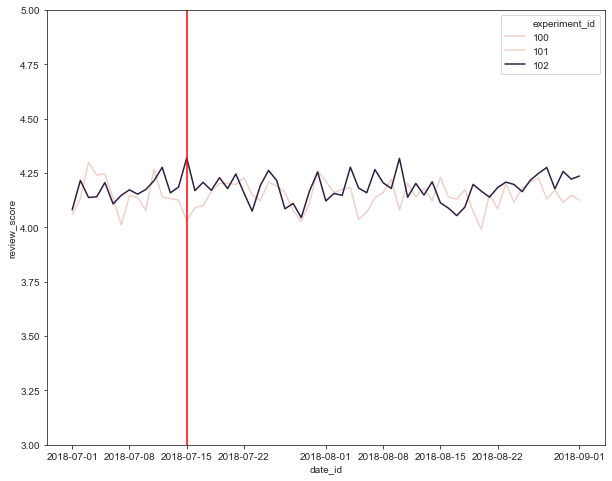

In [33]:
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(data=df.groupby(["date_id", "experiment_id"]).mean().reset_index(),
             x="date_id",
             y="review_score",
             hue="experiment_id",
             ax=ax);
ax.axvline("2018-07-15", color="r")
ax.set_ylim(3,5);

In [41]:
df[df["date_id"] >= "2018-07-15"].groupby("experiment_id").mean()

,review_score
experiment_id,
101,4.146837
102,4.184788


In [35]:
#df.to_csv("data/olist_experiment_data.csv")

In [36]:
df = (pd.read_csv("data/olist_experiment_data.csv")
      .drop(columns="Unnamed: 0"))
df["date_id"] = pd.to_datetime(df["date_id"])

In [37]:
df.head()

,date_id,experiment_id,order_id,review_score
0,2018-07-01,101,daf98958-e883-4480-b4c1-856291d33168,4
1,2018-07-01,101,e294066f-e859-4326-ad1f-a993047a999e,4
2,2018-07-01,101,3d2a58df-dfad-4fd5-887d-f409171c2e06,5
3,2018-07-01,101,654857c3-be8f-4431-8065-b83e4b5a0e31,4
4,2018-07-01,101,dc73aee0-cdb6-49bb-acad-5437022cdd32,1


How do we know if this difference did not just occure by chance?
We have uncertainty because we are looking at a sample and want to generalize to all users.


We use statistics => t-test

Use the Welch's t-test (two independent samples, unequal sample sizes, unequal variance) (Heteroskedasticty)

In [42]:
df_e = df.loc[df["date_id"] >= "2018-07-15"]

group_a = df_e.loc[df["experiment_id"] == 101, "review_score"]
group_b = df_e.loc[df["experiment_id"] == 102, "review_score"]

In [50]:
len(group_a)

19491

In [51]:
len(group_b)

19590

In [44]:
t,p = scipy.stats.ttest_ind(group_a, group_b, equal_var=False)

In [45]:
p

0.0031660921355939507

In [48]:
print(f"the p-value is {round(p*100, 3)}%")

the p-value is 0.317%


In [49]:
print(f"the t-statistic is {round(t,3)}")

the t-statistic is -2.951


## What the *$&% if the p-value?